# 1. Instalacja oraz konfiguracja podstawowych paczek

In [2]:
!pip install tensorflow tensorflow-gpu opencv-python matplotlib

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.6/586.0 MB 36.0 kB/s eta 4:30:40

In [ ]:
!pip list

Package                       Version
----------------------------- --------------------
absl-py                       1.3.0
alabaster                     0.7.12
anaconda-client               1.11.0
anaconda-navigator            2.3.1
anaconda-project              0.11.1
anyio                         3.5.0
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arrow                         1.2.2
astroid                       2.11.7
astropy                       5.1
astunparse                    1.6.3
atomicwrites                  1.4.0
attrs                         21.4.0
Automat                       20.2.0
autopep8                      1.6.0
Babel                         2.9.1
backcall                      0.2.0
backports.functools-lru-cache 1.6.4
backports.tempfile            1.0
backports.weakref             1.0.post1
bcrypt                        3.2.0
beautifulsoup4                4.11.1
binaryornot                   0.4.4
bi

In [ ]:
import tensorflow as tf
import os

2023-03-10 18:20:02.516605: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-10 18:20:02.578771: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-10 18:20:02.940568: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda-11.8/lib64
2023-03-10 18:20:02.940606: W tensorflow/compiler

In [ ]:
# Poniższy kod zapobiega  przydzielaniu przez tensorflow całości pamięci GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

2023-03-10 18:20:03.228506: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-10 18:20:03.244627: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-10 18:20:03.244723: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 2. Weryfikacja, kontrola oraz usunięcie z badania uszkodzonych, wadliwych zdjęć

In [ ]:
import cv2
import imghdr

In [ ]:
data_dir = 'data'

In [ ]:
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

In [ ]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path) #sprawdzam czy mogę załadować zdjęcie do biblioteki opencv
            tip = imghdr.what(image_path) #sprwadzam czy rozsrzeszenie zdjęcia pokrywa się z akceptowalnymi rozszerzeniami
            if tip not in image_exts:
                print('Zdjęcie posiada nieobsługiwane rozszerzenie {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Wystąpił problem ze zdjęciem {}'.format(image_path))

# 3. Ładowanie danych

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
data = tf.keras.utils.image_dataset_from_directory('data') #wywołanie zwróci zestaw danych z wskazanego katalogu, ujednolici, zmniejszy zdjęcia

Found 50 files belonging to 2 classes.


2023-03-10 18:20:03.839366: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-10 18:20:03.840036: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-10 18:20:03.840194: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-10 18:20:03.840302: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at

In [ ]:
data_iterator = data.as_numpy_iterator() #konwersja elementów zestawów danych na iterator, pozwoli nam uzyskać dostęp do poszczególnych danych

In [ ]:
batch = data_iterator.next() #dostęp do zestawu danych, pobranie pierwszej iteracji

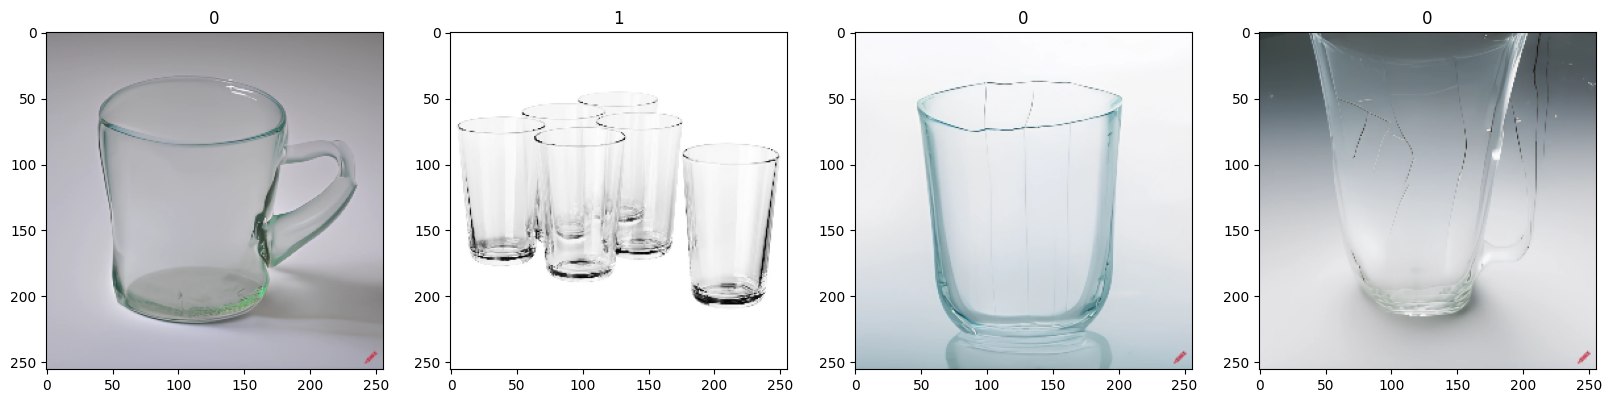

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Wstępne przetwarzanie danych

In [ ]:
# przeskalowanie danych, w celu optymalizacji
data = data.map(lambda x,y: (x/255, y)) # funkcja .map umożliwia operacje na całym zestawie danych
data.as_numpy_iterator().next()

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


(array([[[[0.99607843, 0.99607843, 0.99607843],
          [0.99607843, 0.99607843, 0.99607843],
          [0.99607843, 0.99607843, 0.99607843],
          ...,
          [0.99607843, 0.99607843, 0.99607843],
          [0.99607843, 0.99607843, 0.99607843],
          [0.99607843, 0.99607843, 0.99607843]],
 
         [[0.99607843, 0.99607843, 0.99607843],
          [0.99607843, 0.99607843, 0.99607843],
          [0.99607843, 0.99607843, 0.99607843],
          ...,
          [0.99607843, 0.99607843, 0.99607843],
          [0.99607843, 0.99607843, 0.99607843],
          [0.99607843, 0.99607843, 0.99607843]],
 
         [[0.99607843, 0.99607843, 0.99607843],
          [0.99607843, 0.99607843, 0.99607843],
          [0.99607843, 0.99607843, 0.99607843],
          ...,
          [0.99607843, 0.99607843, 0.99607843],
          [0.99607843, 0.99607843, 0.99607843],
          [0.99607843, 0.99607843, 0.99607843]],
 
         ...,
 
         [[0.99607843, 0.99607843, 0.99607843],
          [0.99607

In [ ]:
train_size = int(len(data)*.7) # część zestawu danych, która będzie odpowiedzalna za trenowanie modelu
val_size = int(len(data)*.2)+1 # część zestwu danych odpowiedzialna za walidacje
test_size = int(len(data)*.1)+1 # część zestawu danych odpowiedzialna za końcowe testy

In [ ]:
train_size

1

In [ ]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 5. Budowa modelu głębokiego uczenia

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [ ]:
model = Sequential()

In [ ]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

# 6. Trenowanie

In [ ]:
logdir='logs'

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
hist = model.fit(train, epochs=5, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/5


2023-03-10 18:20:05.853441: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8700
2023-03-10 18:20:06.318724: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-03-10 18:20:06.320258: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x1e0a6830 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-10 18:20:06.320270: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Ti, Compute Capability 8.6
2023-03-10 18:20:06.323084: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-03-10 18:20:06.388526: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of t

1/1 [==============================] - 3s 3s/step - loss: 0.7296 - accuracy: 0.4375 - val_loss: 2.6369 - val_accuracy: 0.5556
Epoch 2/5
1/1 [==============================] - 0s 148ms/step - loss: 3.6632 - accuracy: 0.3750 - val_loss: 1.1824 - val_accuracy: 0.3333
Epoch 3/5
1/1 [==============================] - 0s 122ms/step - loss: 0.8273 - accuracy: 0.5625 - val_loss: 0.8744 - val_accuracy: 0.3889
Epoch 4/5
1/1 [==============================] - 0s 119ms/step - loss: 0.8070 - accuracy: 0.4688 - val_loss: 0.6270 - val_accuracy: 0.7222
Epoch 5/5
1/1 [==============================] - 0s 112ms/step - loss: 0.7075 - accuracy: 0.5938 - val_loss: 0.6998 - val_accuracy: 0.5556


# 7. Badanie wydajności, wykaz strat

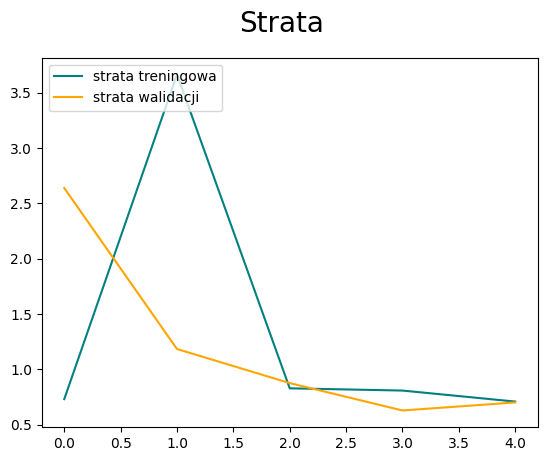

In [ ]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='strata treningowa')
plt.plot(hist.history['val_loss'], color='orange', label='strata walidacji')
fig.suptitle('Strata', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 8. Badanie wydajności, wykaz dokładności

In [ ]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='dokładność treningowa')
plt.plot(hist.history['val_accuracy'], color='orange', label='dokładność walidacji')
fig.suptitle('Dokładność', fontsize=20)
plt.legend(loc="upper left")
plt.show()

NameError: name 'plt' is not defined

# 9. Ocena wydajności modelu

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

# 10. Test

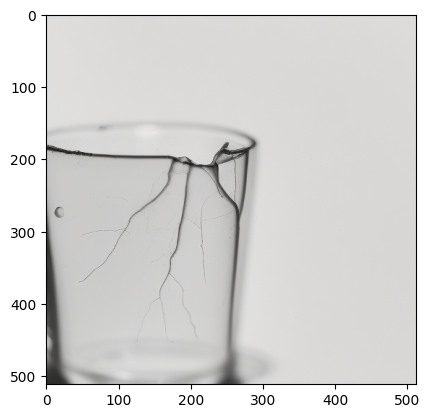

In [ ]:
img = cv2.imread('testing/failure_4.png')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

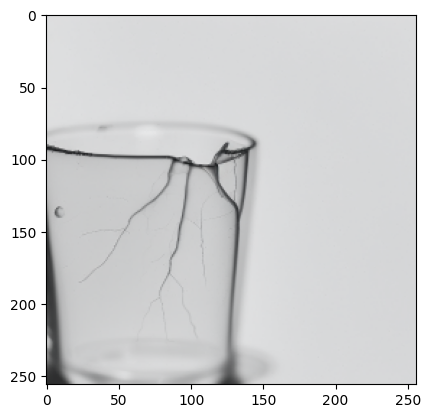

In [ ]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [ ]:
yhat  = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 11ms/step


In [ ]:
yhat

array([[0.38747022]], dtype=float32)

In [ ]:
if yhat > 0.5:
    print(f'Wskazany obraz został sklasyfikowany jako część prawidłowa')
else:
    print(f'Wskazany obraz został sklasyfikowany jako część uszkodzona')

Wskazany obraz został sklasyfikowany jako część uszkodzona


# 9. Zapis modelu

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
model.save(os.path.join('models', 'imageclassicationversionlive.h5'))

In [ ]:
new_model = load_model(os.path.join('models', 'imageclassicationversionlive.h5'))

img = cv2.imread('testing/failure_4.png')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

yhat = model.predict(np.expand_dims(resize/255, 0))
if yhat > 0.5:
    print(f'Wskazany obraz został sklasyfikowany jako część prawidłowa')
else:
    print(f'Wskazany obraz został sklasyfikowany jako część uszkodzona')

# 10. Ocena modelu

In [ ]:
new_model = load_model(os.path.join('models', 'imageclassicationversionlive.h5'))
from sklearn.metrics import classification_report

# Ewaluacja modelu na zbiorze testowym
y_test = []
y_pred = []

for images, labels in test:
    predictions = model.predict(images)
    predictions = np.round(predictions).reshape(-1)
    y_test.extend(labels.numpy())
    y_pred.extend(predictions)

# Obliczenie precyzji, czułości (recall) i F1-score
report = classification_report(y_test, y_pred, target_names=['uszkodzony', 'prawidłowy'], output_dict=True)
print(report)

# Wizualizacja raportu klasyfikacji
import seaborn as sns
import pandas as pd

report_df = pd.DataFrame(report).transpose()
report_df = report_df[:-3]  # Usunięcie zbędnych wierszy (accuracy, macro avg, weighted avg)

plt.figure(figsize=(8, 4))
sns.barplot(x=report_df.index, y='f1-score', data=report_df)
plt.ylim(0, 1)
plt.title('F1-score dla poszczególnych klas')
plt.xlabel('Klasy')
plt.ylabel('F1-score')
plt.show()